# Disaster Reponse Pipeline Creation 


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# import libraries
import pandas as pd
import sqlite3
import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from skmultilearn.model_selection import iterative_train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterMessages.db')
df = pd.read_sql('SELECT * FROM CleanMessages', engine)

# define variables. X is input, Y is target
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1) 

In [5]:
# check to make sure we have at least one instance for each label
labels_with_no_instance = Y.columns[~(Y == 1).any(axis=0)]
Y = Y.drop(labels_with_no_instance, axis=1)

In [7]:
labels_with_no_instance

Index(['child_alone'], dtype='object')

In [8]:
# check for labels that are not binary
(Y.isin([0, 1])).all(axis=0)

related                   False
request                    True
offer                      True
aid_related                True
medical_help               True
medical_products           True
search_and_rescue          True
security                   True
military                   True
water                      True
food                       True
shelter                    True
clothing                   True
money                      True
missing_people             True
refugees                   True
death                      True
other_aid                  True
infrastructure_related     True
transport                  True
buildings                  True
electricity                True
tools                      True
hospitals                  True
shops                      True
aid_centers                True
other_infrastructure       True
weather_related            True
floods                     True
storm                      True
fire                       True
earthqua

Uh oh! Looks like all of our labels are binary except for the 'related' column.
Let's check it out.

In [9]:
cnts = Y.related.value_counts()
print(cnts)
print(cnts / cnts.sum())

1    19906
0     6122
2      188
Name: related, dtype: int64
1    0.759307
0    0.233522
2    0.007171
Name: related, dtype: float64


We only have 188 instances of 'related' not binary, which is 0.7% of the instances in the dataset.
Looks like the non binary values of related are 2's. 
Since the number is so small, we'll drop them from the dataset. The reasoning behind this approach is that by dropping these rows, we transform the problem from a multiclass-multilabel problem, known as a multioutput problem, down to a multilabel problem.


In [10]:
index = Y[Y.related == 2].index
Y = Y.drop(index)
X = X.drop(index)

In [11]:
X.shape, Y.shape

((26028,), (26028, 35))

In [12]:
# original data
df.head(5)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# check the shape of the original data 
df.shape

(26216, 40)

We've dropped 188 rows and 5 columns.

### 2. Write a tokenization class to process the text data

Lemmatization is a way to reduce words to their root or base form. <br>
The process is more accurate if the lemmatizer knows to which part of speech the word belongs. <br>
Therefore, as part of the lemmatization process, we will tag each word with nltk's pos_tag function. <br>
This POS tag is a Treebank POS tag - in order to utilize it with the WordNet lemmatizer, we have to convert the Treebank POS tag to a WordNet POS tag. <br>
Then, we will pass this POS tag to the lemmatizer along with the word.

In [14]:
# define a function that will allow a treebank POS tag to be converted into a WordNet
# POS Tag so the lemmatizer will understand it
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    # default to Noun 
    else:
        return wordnet.NOUN

Removing stop words is another common step in processing text data. Stop words are common words in a language that may potentially confuse a classifier due to their frequency.

We will implement a custom transformer with hyperparameters in order to determine if removing stop words and/or lemmatizing words will have a positive effect on classification efficacy.
This custom transformer follows sklearn's rules for transformers so that it can be used in our processing pipeline.

In [15]:
# implement a custom transformer to determine if removing stops and/or lemmatizing improves model performance

class MessageTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stops=True, lemmatize=True):
        self.remove_stops = remove_stops
        self.lemmatize = lemmatize
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        
        # iterate over supplied messages
        for text in X: 
            # remove all non-alphanumeric characters
            text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
              
            # lower and strip whitespace
            text = text.lower().strip()
    
            # tokenize words - nltk.tokenize.word_tokenize
            words = word_tokenize(text)
            
            if self.lemmatize:
                # tag words with Part of Speech - list of (word, POS) tuples 
                # nltk.pos_tag()
                words_with_pos_tag = pos_tag(words)
                
                if self.remove_stops:
                    # remove stop words
                    # stop_words = nlt.corpus.stopwords of 'english' language
                    words_with_pos_tag = [word for word in words_with_pos_tag if word[0] not in stop_words]
                
                # change pos tags to wordnet pos tags for lemmatizer
                words_with_wordnet_tag = []
    
                for word_with_tag in words_with_pos_tag:
                    word, tag = word_with_tag
                    tag = get_wordnet_pos(tag)
                    words_with_wordnet_tag.append((word, tag))

                # lemmatize
                lemm = WordNetLemmatizer()
                # unpack the (word, pos) tuple into the Lemmatizer to give better lemmatization 
                # lemmatization is more effective when it knows the correct part of speech
                words = [lemm.lemmatize(*w) for w in words_with_wordnet_tag]
                
            else:
                if self.remove_stops:
                    words = [word for word in words if word not in stop_words]

            # join cleaned words back into single document
            X_transformed.append(' '.join(words))
        
        return X_transformed    

Show off the custom transformer

In [16]:
text = ["We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words"]
text.append("Here is another example of words. Isn't it great how words are?")

text

['We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words',
 "Here is another example of words. Isn't it great how words are?"]

In [17]:
MessageTokenizer(remove_stops=False, lemmatize=True).transform(text)

['we would not want these word take up space in our database or take up valuable processing time for this we can remove them easily by store a list of word that you consider to be stop word',
 'here be another example of word isn t it great how word be']

### 3. Build a first machine learning pipeline
A pipeline allows us to wrap all of our data transformation steps into a neat little package.

In [18]:
pipeline = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', RandomForestClassifier())
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

Since this is a multilabel classification, I looked into the iterative train-test-split supplied by skmultilearn.
The idea with the iterative train test split is that in theory it can provide better label representation for mutli label problems. Here I will compare whether this train test split results in appropriate label representation for the train set.

In [19]:
# get the proportion of labels in the original data
compare = pd.DataFrame(Y.mean(axis=0), columns=['dataset'])

In [20]:
compare.head()

,dataset
related,0.764792
request,0.171892
offer,0.004534
aid_related,0.417243
medical_help,0.080068


In [21]:
# employ skmultilearn's iterative train test split.
# have to reshape the X values to be multidimensional since that's what this expects

X_train, y_train, X_test, y_test = iterative_train_test_split(X.values.reshape(-1,1), Y.values, test_size = 0.25)

In [22]:
# we want to see how the iterative split did with label proportions
compare['train_set'] = y_train.mean(axis=0)

In [23]:
# normal train test split - how does it compare
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.25)

In [24]:
compare['normal_split'] = y_train2.values.mean(axis=0)

In [25]:
compare

,dataset,train_set,normal_split
related,0.764792,0.764817,0.764869
request,0.171892,0.136571,0.173352
offer,0.004534,0.004559,0.004354
aid_related,0.417243,0.417243,0.417909
medical_help,0.080068,0.087188,0.081861
medical_products,0.050446,0.052405,0.049793
search_and_rescue,0.027816,0.028636,0.027765
security,0.018096,0.019261,0.018903
military,0.033041,0.042006,0.032324
water,0.064239,0.061985,0.064341


In [27]:
diff = pd.DataFrame(compare['dataset'] - compare['normal_split'])
diff.columns = ['dataset - normalsplit']
diff['dataset - iterative split'] = compare['dataset'] - compare['train_set']
diff

,dataset - normalsplit,dataset - iterative split
related,-0.000077,-0.000026
request,-0.001460,0.035321
offer,0.000179,-0.000026
aid_related,-0.000666,0.000000
medical_help,-0.001793,-0.007121
medical_products,0.000653,-0.001959
search_and_rescue,0.000051,-0.000820
security,-0.000807,-0.001165
military,0.000717,-0.008965
water,-0.000102,0.002254


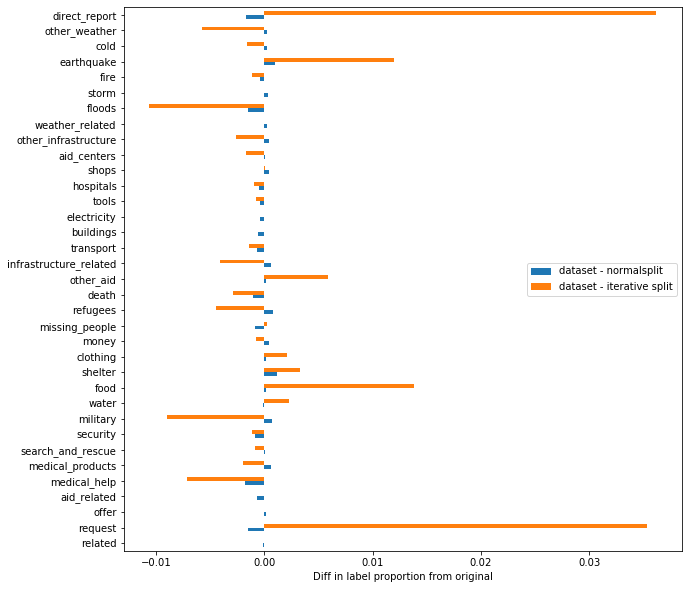

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10,10))
diff.plot(kind='barh', ax=ax)
plt.xlabel('Diff in label proportion from original')
plt.show()


It seems that the normal train-test-split does a fine, if not better job, of capturing nearly the same proportion of labels as in the original dataset. <br>
Since we will be using a OneVsRest strategy, we are interested in keeping the split proportion close to that of the original dataset.

In [29]:
# normal train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [30]:
# split the train into train and validation set - we'll hold the test set out for the very end.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)

In [31]:
# fit the pipeline!
pipeline.fit(X_train, y_train)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('msg_tokenizer', MessageTokenizer(lemmatize=True, remove_stops=True)), ('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### 5. Test the fitted model on the train data and the validation data.
We'll save the test data for the very end.

In [32]:
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)

In [33]:
y_prob_train = pipeline.predict_proba(X_train)
y_prob_val = pipeline.predict_proba(X_val)

In [34]:
y_pred_train.shape, y_pred_val.shape, y_test.shape

((16657, 35), (4165, 35), (5206, 35))

In [53]:
# iterate thru all the labels and check the precision, recall, and f1 score on each individual label for the training data 

from sklearn.metrics import confusion_matrix

y_pred_train = pd.DataFrame(y_pred_train, columns=Y.columns)
y_train = pd.DataFrame(y_train, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_train[col], y_pred_train[col]))
    print(confusion_matrix(y_train[col], y_pred_train[col]))


print("""
Example output:

related 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3920
         1.0       0.99      0.99      0.99     12737

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.99      0.99      0.99     16657
weighted avg       0.99      0.99      0.99     16657

[[ 3856    64]
 [   68 12669]]
request 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     13952
         1.0       0.93      1.00      0.96      2705

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.97      0.99      0.98     16657
weighted avg       0.99      0.99      0.99     16657

[[13755   197]
 [   11  2694]]

....... lots more
""")

related 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3924
           1       0.99      0.99      0.99     12733

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.99      0.99      0.99     16657
weighted avg       0.99      0.99      0.99     16657

[[ 3856    68]
 [   64 12669]]
request 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     13766
           1       1.00      0.93      0.96      2891

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.99      0.97      0.98     16657
weighted avg       0.99      0.99      0.99     16657

[[13755    11]
 [  197  2694]]
offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16575
           1       1.00      0.74      0.85        82

   micro avg       1.00      1.00      1.00     16657
   macro avg       1.00      0.87     

In [56]:
# looks good on the training data - how does it do on validation data?

y_pred_val = pd.DataFrame(y_pred_val, columns=Y.columns)
y_val = pd.DataFrame(y_val, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_val[col], y_pred_val[col]))
    print(col, '\n', confusion_matrix(y_val[col], y_pred_val[col]))
    print('\n')

print("""
Example output:

related 
               precision    recall  f1-score   support

         0.0       0.52      0.64      0.58       827
         1.0       0.91      0.86      0.88      3338

   micro avg       0.81      0.81      0.81      4165
   macro avg       0.71      0.75      0.73      4165
weighted avg       0.83      0.81      0.82      4165

related 
 [[ 528  299]
 [ 481 2857]]


request 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      3804
         1.0       0.43      0.81      0.56       361

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.71      0.85      0.75      4165
weighted avg       0.93      0.89      0.90      4165

request 
 [[3415  389]
 [  68  293]]
""")


Example output:

related 
               precision    recall  f1-score   support

         0.0       0.52      0.64      0.58       827
         1.0       0.91      0.86      0.88      3338

   micro avg       0.81      0.81      0.81      4165
   macro avg       0.71      0.75      0.73      4165
weighted avg       0.83      0.81      0.82      4165

related 
 [[ 528  299]
 [ 481 2857]]


request 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      3804
         1.0       0.43      0.81      0.56       361

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.71      0.85      0.75      4165
weighted avg       0.93      0.89      0.90      4165

request 
 [[3415  389]
 [  68  293]]



The performance of the classifier on the training data seems fairly good overall. <br>
However, it's performance on the validation data, which is poor, seems to indicate that it's overfitting the training data. <br>
Another way to gauge the results of a multi-label output is by computing the hamming loss. <br>
Hamming loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.

In [57]:
# compute hamming loss as well
from sklearn.metrics import hamming_loss, make_scorer

# drop related column while measuring this because there are some rows with related=2
print('Hamming loss on train: ', hamming_loss(y_train, y_pred_train))

print('Hamming loss on val: ', hamming_loss(y_val, y_pred_val))

Hamming loss on train:  0.007660443056973045
Hamming loss on val:  0.05938604013033785


Still not too bad overall. The hamming loss tells us that on the validation data, 6% of all labels applied were incorrect. <br>
However, when you consider that many labels are very sparsely represented, we should acknowledge that it is perhaps trivial to achieve this score. 

### Test three different classifiers before tuning hyper params

We will test out
1. Multilayer Perceptron - Directly supports multi-label - <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier"> link </a>
2. RandomForestClassifier in a OneVsRest framework.
3. A LinearSVC wrapped in OneVsRestClassifier. <br> In essence, train a separate model to predict for each individual label. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html"> LinearSVC link </a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html"> OneVsRest link </a>

In [44]:
# import them

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [68]:
# a quick and dirty function to look at model results
from sklearn.metrics import confusion_matrix

def model_compare(y_true, y_pred):
    y_pred2 = pd.DataFrame(y_pred, columns=Y.columns)
    y_train2 = pd.DataFrame(y_train, columns=Y.columns)

    for col in Y.columns:
        print(col, '\n', classification_report(y_train2[col], y_pred2[col]))
        
        print('\n', confusion_matrix(y_train2[col], y_pred2[col]))
        
    print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")
    

In [46]:
pipeline_svc = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(LinearSVC()))
])

pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_train)



In [60]:
model_compare(y_train, y_pred_svc)

print("""
Example output:

related 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      3758
           1       0.98      0.97      0.97     12899

   micro avg       0.96      0.96      0.96     16657
   macro avg       0.94      0.95      0.94     16657
weighted avg       0.96      0.96      0.96     16657


 [[ 3499   259]
 [  425 12474]]
request 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     14085
           1       0.83      0.93      0.88      2572

   micro avg       0.96      0.96      0.96     16657
   macro avg       0.91      0.95      0.93     16657
weighted avg       0.96      0.96      0.96     16657


 [[13595   490]
 [  171  2401]]
""")


Example output:

related 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      3758
           1       0.98      0.97      0.97     12899

   micro avg       0.96      0.96      0.96     16657
   macro avg       0.94      0.95      0.94     16657
weighted avg       0.96      0.96      0.96     16657


 [[ 3499   259]
 [  425 12474]]
request 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     14085
           1       0.83      0.93      0.88      2572

   micro avg       0.96      0.96      0.96     16657
   macro avg       0.91      0.95      0.93     16657
weighted avg       0.96      0.96      0.96     16657


 [[13595   490]
 [  171  2401]]



In [62]:
# try it on the validation set
y_pred_val_svc = pipeline_svc.predict(X_val)

In [64]:
X_val.shape, y_val.shape, y_pred_val_svc.shape

((4165,), (4165, 35), (4165, 35))

In [82]:

for idx, col in enumerate(Y.columns):
    print(idx)
    print(col, '\n', classification_report(y_val.values[:, idx], y_pred_val_svc[:, idx]))
    print(confusion_matrix(y_val.values[:, idx], y_pred_val_svc[:, idx]))

print(f"Hamming Loss {hamming_loss(y_val, y_pred_val_svc)}")


print("""

Example output: 

related 
               precision    recall  f1-score   support

           0       0.65      0.52      0.58      1009
           1       0.86      0.91      0.88      3156

   micro avg       0.82      0.82      0.82      4165
   macro avg       0.75      0.71      0.73      4165
weighted avg       0.81      0.82      0.81      4165

[[ 521  488]
 [ 277 2879]]
1
request 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      3483
           1       0.74      0.55      0.63       682

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.83      0.76      0.79      4165
weighted avg       0.89      0.89      0.89      4165

[[3349  134]
 [ 304  378]]
 """)



Example output: 

related 
               precision    recall  f1-score   support

           0       0.65      0.52      0.58      1009
           1       0.86      0.91      0.88      3156

   micro avg       0.82      0.82      0.82      4165
   macro avg       0.75      0.71      0.73      4165
weighted avg       0.81      0.82      0.81      4165

[[ 521  488]
 [ 277 2879]]
1
request 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      3483
           1       0.74      0.55      0.63       682

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.83      0.76      0.79      4165
weighted avg       0.89      0.89      0.89      4165

[[3349  134]
 [ 304  378]]
 


In [83]:
# hamming loss on the validation set
print(f"Hamming Loss {hamming_loss(y_val, y_pred_val_svc)}")

Hamming Loss 0.05308866403704339


In [84]:
pipeline_mlp = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', MLPClassifier())
])

pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_train)
y_pred_val_mlp = pipeline_mlp.predict(X_val)

In [0]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_mlp)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_mlp)}")

In [ ]:
Hmmmmmmmmmmm. Looks like that neural net is way overfitting

In [0]:
pipeline_rf = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_train)
y_pred_val_rf = pipeline_rf.predict(X_val)

In [0]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_rf)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_rf)}")

The SVC Classifier is not as good at distinguishing between the majority and the minority classes. Accuracy on the individual labels is worse, and Hamming score is worse.

In [98]:
# tune the grid with hamming loss  - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html
# make a custom scorer https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
from sklearn.metrics import hamming_loss, make_scorer
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)


In [ ]:
# create a DenseTranformer class to make sure the output is correct for the GaussianNB

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
pipeline_nb = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer(tokenizer=tokenize)),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # make sure the output is dense, not sparse - needed for GaussianNB
    ('dense', DenseTransformer()),
    # classifier - one classifier per label
    ('clf', MultiOutputClassifier(estimator=GaussianNB()))
])

pipeline_nb.fit(X_train.values, y_train)
y_pred_nb = pipeline_nb.predict(X_train.values)

model_compare(y_pred_nb, y_train)

Choosing to go with the RandomForest model because it seems to yield the best results on training set.

### 6. Improve your model
Use grid search to find better parameters. 

In [1]:
search_params = {
    'msg_tokenizer__remove_stops': [False, True],
    'msg_tokenizer__lemmatize': [False, True],
    'count_vec__ngram_range': [(1,1), (1,2), (1,3)],
    'count_vec__max_features': [None, 100, 500, 1000],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__use_idf': [False, True],
    'tfidf__smooth_idf': [False, True],
    'clf__estimator__n_estimators': [10, 100, 500],
    'clf__estimator__max_depth': [None, 50, 100, 500],
    'clf__estimator__bootstrap': [True, False],
    'clf__estimator__class_weight': [None, 'balanced']
}

cv = RandomizedSearchCV(pipeline, search_params, n_iter=5, n_jobs=-1, scoring=hamming_scorer)
search = cv.fit(X_train, y_train)

NameError: name 'RandomizedSearchCV' is not defined

In [ ]:
cv2 = RandomizedSearchCV(pipeline, search_params, n_iter=10, n_jobs=-1, scoring=hamming_score)
search2 = cv.fit(X_train, y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.